In [1]:
import pandas as pd
from statsmodels.regression.linear_model import OLS
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tools.eval_measures import mse
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from statsmodels.formula.api import ols

In [4]:
# Dataset 
df = pd.read_excel('Folds5x2_pp.xlsx',sheet_name="Sheet1")
print('Number of rows:', df.shape[0])
print('Each row represents the feature values collected for an observation.')
print('Number of columns:', df.shape[1])
print('Each column represents values for the Features: hourly average ambient variables Temperature (AT), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant.')

Number of rows: 9568
Each row represents the feature values collected for an observation.
Number of columns: 5
Each column represents values for the Features: hourly average ambient variables Temperature (AT), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant.


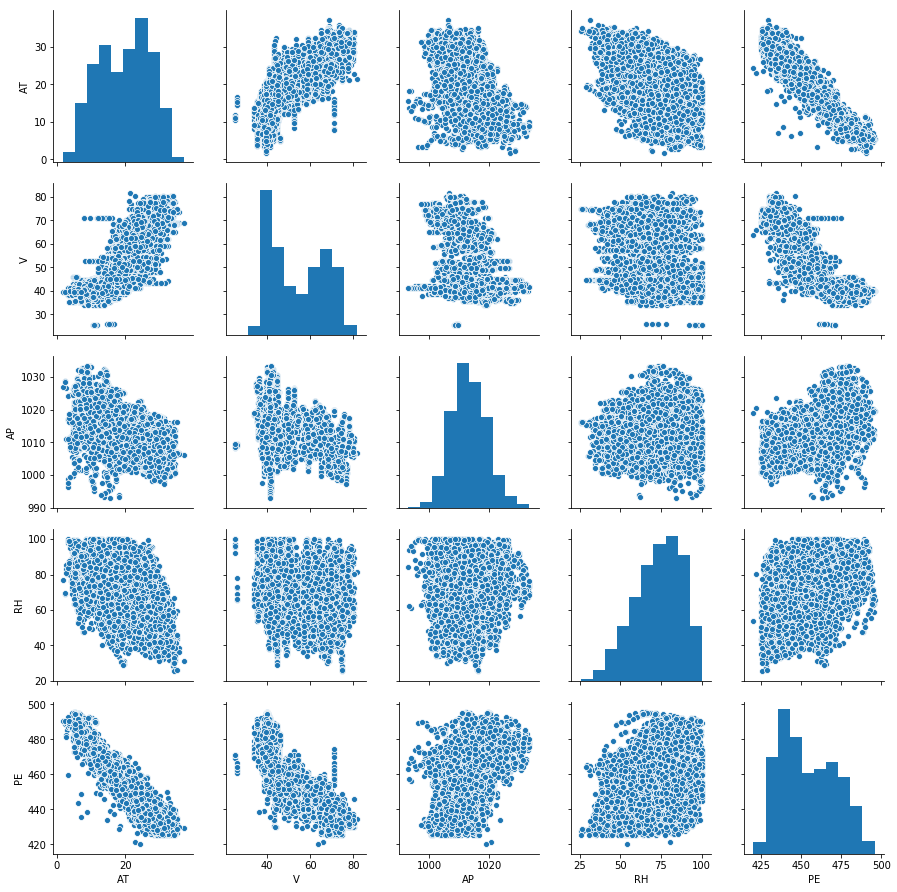

In [5]:
# Pairwise Scatter Plots
sns.pairplot(df)
plt.savefig('scatter.png')

In [6]:
# Correlation Coefficients
df.corr()

,AT,V,AP,RH,PE
AT,1.000000,0.844107,-0.507549,-0.542535,-0.948128
V,0.844107,1.000000,-0.413502,-0.312187,-0.869780
AP,-0.507549,-0.413502,1.000000,0.099574,0.518429
RH,-0.542535,-0.312187,0.099574,1.000000,0.389794
PE,-0.948128,-0.869780,0.518429,0.389794,1.000000


In [7]:
# Statistics on variables
print('Printing stats...\n',df.describe(),'\n\n')

print('IQR for AT...\n\t',25.720000-13.510000)
print('Range for AT ... \n\t',37.110000-1.810000)

print('IQR for V...\n\t',66.540000-41.740000)
print('Range for V ...\n\t',81.560000-25.36000)

print('IQR for AP...\n\t',1017.260000-1009.100000)
print('Range for AP...\n\t',1033.300-992.8900 )

print('IQR for RH...\n\t',84.830000-63.327500)
print('Range for RH...\n\t',100.1600- 25.560)

print('IQR for EP...\n\t',468.430000-439.750000)
print('Range for EP... \n\t',495.760-420.260 )

Printing stats...
                 AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000 


IQR for AT...
	 12.209999999999999
Range for AT ... 
	 35.3
IQR for V...
	 24.800000000000004
Range for V ...
	 56.2
IQR for AP...
	 8.159999999999968
Range for AP...
	 40.40999999999997
IQR for RH...
	 21.502499999999998
Range for RH...
	 74.6
IQR for EP...
	 28.680000000000007
Range for EP... 
	 75.5


,beta0,beta1,R^2,MSE,t-statistic,p-value
AT,496.055,-2.18753,0.895949,31.1295,-287.002,<.00001
V,508.615,-1.09571,0.667873,99.3645,-138.695,<.00001
AP,-1078.98,1.51098,0.269893,218.431,59.4659,<.00001
RH,419.455,0.428073,0.132252,259.609,38.183,<.00001


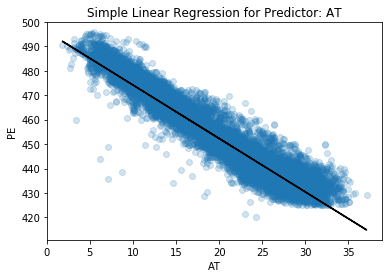

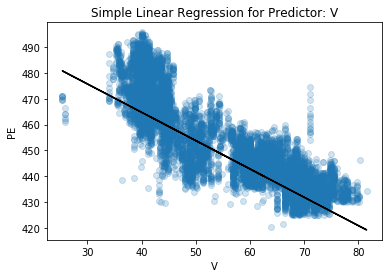

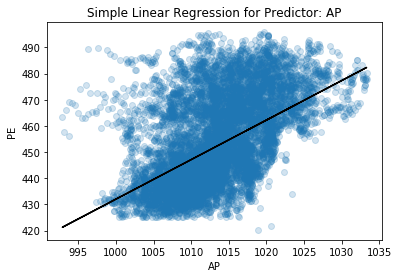

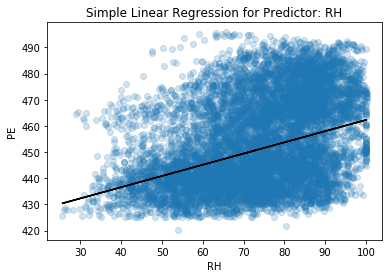

In [8]:
# Simple Linear Regression
def calc_coeff(x,y):
    xbar = x.median()
    ybar = y.median()
    
    # Calculate coefficents
    numerator = 0
    x_sqsum = 0
    y_sqsum = 0
    for xx,yy in zip(x,y):
        numerator = numerator + (xx-xbar)*(yy-ybar)
        x_sqsum = x_sqsum + (xx-xbar)**2
        y_sqsum = y_sqsum + (yy-ybar)**2
    beta1 = numerator/x_sqsum
    beta0 = ybar - beta1*xbar
    d.loc[x.name,'beta1'] = beta1
    d.loc[x.name,'beta0'] = beta0
   
    # Calculate r^2 Error
    r_sq = (numerator / (np.sqrt(x_sqsum)*np.sqrt(y_sqsum)))**2
    d.loc[x.name,'R^2'] = r_sq
    # Calculate MSE
    rss = 0
    for xi,yi in zip(x,y):
        yhat = beta0 + beta1*xi
        rss = rss + (yi - yhat)**2

    d.loc[x.name,'MSE'] = rss/(len(y))
    
    # Plot scatter plot and Linear Regression line
    plot_lr(x,y,beta0,beta1)
    SE = calc_stderr(x,y,beta0,beta1)
    d.loc[x.name,'t-statistic'] = beta1 / SE
    
def calc_stderr(x,y,beta0,beta1):
    predicted = beta0 + beta1*x
    sse = 0
    for yi,yihat in zip(df.iloc[:,-1],predicted):
        sse = sse + ((yi - yihat)**2)
    sigma_sq = sse /(df.shape[0] - 2)

    xbar = np.median(x)
    x_sq = 0
    for xx in x:
        x_sq = x_sq + ((xx-xbar)**2)
    SE = np.sqrt(sigma_sq / x_sq)    
    return SE    
    
def plot_lr(x,y,beta0,beta1):
    plt.figure()
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    title = 'Simple Linear Regression for Predictor: %s' % x.name
    plt.title(title)
    plt.scatter(x,y,alpha=0.2)
    plt.plot(x, beta0 + beta1*x,color="black")

d = pd.DataFrame(columns = ['beta0','beta1','R^2','MSE','t-statistic','p-value'],index = ['AT','V','AP','RH'])
calc_coeff(df['AT'],df['PE'])
calc_coeff(df['V'],df['PE'])
calc_coeff(df['AP'],df['PE'])
calc_coeff(df['RH'],df['PE'])

d['p-value'] = ['<.00001','<.00001','<.00001','<.00001']
d

In [10]:
# Multiple linear regression
lr = LinearRegression().fit(df.iloc[:,0:4],df.iloc[:,-1])
df_lr = pd.DataFrame(columns=['Estimated Coefficient (beta_j)','SE','t-statistic','p-values(alpha=0.05)'],index = ['AT','V','AP','RH','intercept'])
coeff =  list(lr.coef_)
coeff.append(lr.intercept_)
print('MSE for multiple linear regression is ', mean_squared_error(df['PE'],lr.predict(df.iloc[:,0:4])))
df_lr['Estimated Coefficient (beta_j)'] = coeff

predicted = lr.predict(df.iloc[:,0:4])
r_2 = lr.score(df.iloc[:,0:4],df.iloc[:,-1])
print('Multiple Linear Regression \n R^2: \t\t\t\t', r_2)
# Estimate variance of noise using SSE/n-p+1
sse = 0
for yi,yihat in zip(df.iloc[:,-1],predicted):
    sse = sse + ((yi - yihat)**2)
sigma_sq = sse /(df.shape[0] - 2)

def calc_stderr(x,sig_sq):
    xbar = np.median(x)
    x_sq = 0
    for xx in x:
        x_sq = x_sq + ((xx-xbar)**2)
    SE = np.sqrt(sig_sq / x_sq)
    
    return SE

# Calculate standard error using estimated value for sigma
SEb1 = calc_stderr(df['AT'].values, sigma_sq)
SEb2 = calc_stderr(df['V'].values, sigma_sq)
SEb3 = calc_stderr(df['AP'].values, sigma_sq)
SEb4 = calc_stderr(df['RH'].values, sigma_sq)
df_lr['SE'] = [SEb1,SEb2,SEb3,SEb4,'-']

t = []
# Calculate t-statistic
for est, se in zip(df_lr['Estimated Coefficient (beta_j)'][0:4],df_lr['SE'][0:4]):
    tt = est/se
    t.append(tt)
t.append('-')
df_lr['t-statistic'] = t
p_vals = ['<.00001','<.00001','<.00001','<.00001','-']
df_lr['p-values(alpha=0.05)'] = p_vals
df_lr

MSE for multiple linear regression is  20.767397532535014
Multiple Linear Regression 
 R^2: 				 0.9286960898122536


,Estimated Coefficient (beta_j),SE,t-statistic,p-values(alpha=0.05)
AT,-1.977513,0.0062255,-317.647,<.00001
V,-0.233916,0.00361171,-64.7661,<.00001
AP,0.062083,0.00783475,7.92405,<.00001
RH,-0.158054,0.00317087,-49.8457,<.00001
intercept,454.609274,-,-,-


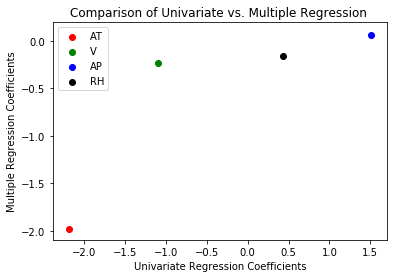

In [11]:
# (e) Comparison of Univariate vs. Multiple Regression
plt.figure()
plt.title('Comparison of Univariate vs. Multiple Regression ')
plt.xlabel('Univariate Regression Coefficients')
plt.ylabel('Multiple Regression Coefficients')
colors = ['r','g','b','k']
labels = ['AT','V','AP','RH']
i = 0
for x,y in zip(d['beta1'],df_lr['Estimated Coefficient (beta_j)']):
    plt.scatter(x,y,color = colors[i],label=labels[i])
    i = i + 1
plt.legend()


In [12]:
# (f) Polynomial Regression
def poly_reg(x,y):
    df_poly = pd.DataFrame(columns=[x.name,x.name+'2',x.name+'3',y.name])
    poly = PolynomialFeatures(degree = 3,include_bias = False)
    x_poly = poly.fit_transform(x.values.reshape(-1,1))
    
    df_poly[[x.name,x.name+'2',x.name+'3']] = pd.DataFrame(x_poly)
    df_poly[[y.name]] = pd.DataFrame(y)
    poly.fit(x_poly,y) 
    
    form = 'PE ~ %s + %s2 + %s3' %(x.name,x.name, x.name)
    lr = ols(formula=form, data=df_poly).fit()
    multi.loc[x.name,['x','x^2','x^3']] = lr.pvalues.values[1:]
    multi.loc[x.name,['MSE']] = mse(y,lr.predict(df_poly[[x.name,x.name+'2',x.name+'3']]))
    print('Poly reg MSE for ', x.name, ' is ', mse(y,lr.predict(df_poly[[x.name,x.name+'2',x.name+'3']])))
    #print(lr.summary())
     
multi = pd.DataFrame(columns=['x','x^2','x^3','MSE'],index = ['AT','V','AP','RH'])
poly_reg(df['AT'],df['PE'])
poly_reg(df['V'],df['PE'])
poly_reg(df['AP'],df['PE'])
poly_reg(df['RH'],df['PE'])
multi

Poly reg MSE for  AT  is  25.664339681466892
Poly reg MSE for  V  is  65.52527085562208
Poly reg MSE for  AP  is  211.1974222476572
Poly reg MSE for  RH  is  246.47407323169548


,x,x^2,x^3,MSE
AT,7.89815e-07,8.83305e-73,3.65218e-110,25.6643
V,2.52659e-05,0.768497,0.0137349,65.5253
AP,4.50274e-17,3.6667e-17,8.26415e-18,211.197
RH,0.000377251,9.39543e-06,1.44028e-05,246.474


In [13]:
# (g)
def interaction_reg(df):
    form = 'PE ~ AT + V + AP + RH + AT:V + AT:AP + AT:RH + V:AP + V:RH + AP:RH'
    lr = ols(formula =form,data=df).fit()
    inter['coef'] = lr.params.values
    inter['SE'] = lr.bse.values
    inter['p-values'] = lr.pvalues.values
    print('MSE for interaction regression, ', mse(df['PE'],lr.predict(df.iloc[:,0:4])))
    print(lr.summary())
    
inter = pd.DataFrame(columns=['coef','SE','p-values'],index = ['intercept','AT','V','AT','RH','AT:V','AT:AP','AT:RH','V:AP','V:RH','AP:RH'])
interaction_reg(df)
inter

    

MSE for interaction regression,  18.551068885394656
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Tue, 05 Feb 2019   Prob (F-statistic):               0.00
Time:                        15:32:40   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


,coef,SE,p-values
intercept,685.782468,78.640060,3.231607e-18
AT,-4.347014,2.373139,6.701873e-02
V,-7.674858,1.350761,1.371251e-08
AT,-0.152355,0.076817,4.735732e-02
RH,1.570907,0.773350,4.225213e-02
AT:V,0.020971,0.000899,3.333358e-117
AT:AP,0.001759,0.002339,4.520509e-01
AT:RH,-0.005230,0.000812,1.216944e-10
V:AP,0.006812,0.001327,2.877026e-07
V:RH,0.000839,0.000489,8.619366e-02


In [14]:
# (h)
def train_reg(df):
    df_train = df.sample(frac=0.7,replace = False)  
    df_train.reset_index(drop=True, inplace=True)
    
    df_test = pd.DataFrame(df.loc[~df.index.isin(df_train.index)])
    df_test.reset_index(drop=True, inplace=True)
    
    
    lr_train_regular = OLS(df_train.iloc[:,-1],df_train.iloc[:,0:4]).fit()
    
    train_pred = lr_train_regular.predict(df_train.iloc[:,0:4])
    train_reg_MSE = mse(df_train.loc[:,'PE'],train_pred)
    print('Train MSE using 70% of data: \n \t\t\t\t', train_reg_MSE)
    
    test_predictions = lr_train_regular.predict(df_test.iloc[:,0:4])
    test_reg_MSE = mse(df_test.loc[:,'PE'],test_predictions)
    print('Test MSE using 30% of data: \n \t\t\t\t:',test_reg_MSE)
    
    print('No interaction or nonlinear terms teset LR: ...\n',lr_train_regular.summary(),'\n\n')
    
    # Set up train and test data for interaction and quadratic term analysis
    for feature in df_train.columns[0:4]:
        df_train[[feature,feature+'^2']] = quad_nonlinear(df_train[feature])
        df_test[[feature,feature+'^2']] = quad_nonlinear(df_test[feature])
        for f2 in df_train.columns[0:4]:
            if feature == f2 or feature+'*'+f2 in df_train.columns or f2+'*'+feature in df_train.columns:
                continue
                
            df_train[feature+'*'+f2] = df_train[feature]*df_train[f2]
            df_test[feature+'*'+f2] = df_test[feature]*df_test[f2]
    Xtrain = df_train.loc[:,['AT', 'V', 'AP', 'RH', 'AT^2', 'AT*V', 'AT*AP',
        'V*RH', 'AP^2', 'RH^2']]
    Ytrain = df_train.loc[:,'PE']
    lr_train = OLS(Ytrain,Xtrain).fit()
    train_pred = lr_train.predict(Xtrain)
    train_MSE = mse(Ytrain,train_pred)
    print('Features and interaction terms found using Backward Selection...\n',list(Xtrain.columns))
    print('Train MSE using model with all significant p-values:\n\t\t\t',train_MSE)
    
    Xtest = df_test.loc[:,['AT', 'V', 'AP', 'RH', 'AT^2', 'AT*V', 'AT*AP',
        'V*RH', 'AP^2', 'RH^2']]
    Ytest = df_test.loc[:,'PE']     
    test_predictions = lr_train.predict(Xtest)
    test_combo_MSE = mse(Ytest,test_predictions)
    print('TEST MSE using model with all significant p-values:\n \t\t\t\t', test_combo_MSE)
    print(lr_train.summary())
    
    
    
def quad_nonlinear(x):
    poly = PolynomialFeatures(degree = 2, include_bias = False)
    x_poly = poly.fit_transform(x.values.reshape(-1,1))
    return pd.DataFrame(x_poly,columns=[x.name,x.name+'^2'])
       
train_reg(df)

Train MSE using 70% of data: 
 				 25.39959839101837
Test MSE using 30% of data: 
 				: 26.978925490305123
No interaction or nonlinear terms teset LR: ...
                             OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.362e+07
Date:                Tue, 05 Feb 2019   Prob (F-statistic):               0.00
Time:                        15:32:46   Log-Likelihood:                -20337.
No. Observations:                6698   AIC:                         4.068e+04
Df Residuals:                    6694   BIC:                         4.071e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|

In [18]:
# (i) KNN Regression
def knr(k,Xtrain,Ytrain,Xtest,Ytest):
    knr = KNeighborsRegressor(n_neighbors = k)
    knr.fit(Xtrain,Ytrain)
    
    pred_train = knr.predict(Xtrain)
    mse_train = mse(Ytrain,pred_train)
    
    pred_test = knr.predict(Xtest)
    mse_test = mse(Ytest,pred_test)

    return mse_train, mse_test

def normalize(df_train,df_test):
    new_train = pd.DataFrame()
    new_test = pd.DataFrame()
    for feat in df_train.columns[0:4]:
        new_train[feat] = (df_train[feat] - df_train[feat].median())/(df_train[feat].max()- df_train[feat].min())
        new_test[feat] = (df_test[feat] - df_test[feat].median())/(df_test[feat].max()- df_test[feat].min())
    
    return new_train, new_test

df_train = df.sample(frac=0.7,replace = False)  
df_train.reset_index(drop=True, inplace=True)
    
df_test = pd.DataFrame(df.loc[~df.index.isin(df_train.index)])
df_test.reset_index(drop=True, inplace=True) 

neighbors = np.arange(1,101)
train_err_raw = np.empty(len(neighbors))
test_err_raw = np.empty(len(neighbors))

Xtrain = df_train.iloc[:,0:4]
Ytrain = df_train.iloc[:,-1]
Xtest = df_test.iloc[:,0:4]
Ytest = df_test.iloc[:,-1]
for i,k in enumerate(neighbors):
    train_err,test_err = knr(k,Xtrain,Ytrain,Xtest,Ytest)
    
    train_err_raw[i] = train_err
    test_err_raw[i] = test_err

new_train, new_test = normalize(df_train,df_test)
Xtrain = new_train
Ytrain = df_train.iloc[:,-1]
Xtest = new_test
Ytest = df_test.iloc[:,-1]

train_err_norm = np.empty(len(neighbors))
test_err_norm = np.empty(len(neighbors))
for i,k in enumerate(neighbors):   
    train_err,test_err = knr(k,Xtrain,Ytrain,Xtest,Ytest)
    
    train_err_norm[i] = train_err
    test_err_norm[i] = test_err
    

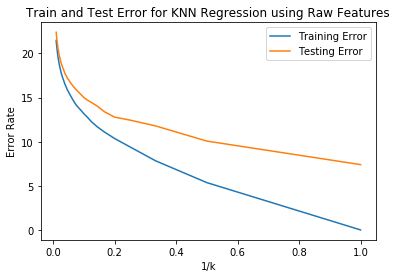

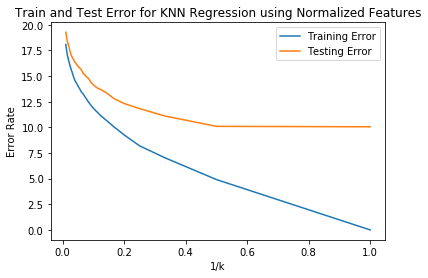

In [19]:
# KNN Regression plots
plt.figure()
plt.plot(1/neighbors, train_err_raw, label='Training Error')
plt.plot(1/neighbors, test_err_raw, label='Testing Error')
plt.xlabel('1/k')
plt.ylabel('Error Rate')
plt.title('Train and Test Error for KNN Regression using Raw Features')
plt.legend()

plt.figure()
plt.plot(1/neighbors, train_err_norm, label='Training Error')
plt.plot(1/neighbors, test_err_norm, label='Testing Error')
plt.xlabel('1/k')
plt.ylabel('Error Rate')
plt.title('Train and Test Error for KNN Regression using Normalized Features')
plt.legend()


